In [389]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import math
from sklearn.cluster import KMeans
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, pairwise_logrank_test
import seaborn as sns

Preprocessing metadata.

In [537]:
ROOT_PATH = 'C:/Users/jorda/BU/BF550/Project2/Breast_Cancer'
df_meta = pd.read_csv(ROOT_PATH+"/brca_metabric_clinical_data.tsv", delimiter="\t")

In [538]:
# Initialize an empty dictionary to store meta data
metabric_meta_dict = {}

# Filter the input dataframe to include only samples with the "LumA" subtype
df_luma = df_meta[df_meta["Pam50 + Claudin-low subtype"] == "LumA"]

# Iterate over each row in the filtered dataframe
for _, row in df_luma.iterrows():
    # For each row, create an entry in the dictionary using the "Patient ID" as the key
    metabric_meta_dict[row["Patient ID"]] = {}

    # Populate the dictionary entry with RFS (Relapse Free Status) and RFM (Relapse Free Status Months)
    metabric_meta_dict[row["Patient ID"]]["RFS"] = row["Relapse Free Status"]
    metabric_meta_dict[row["Patient ID"]]["RFM"] = row["Relapse Free Status (Months)"]


In [539]:
#print(metabric_meta_dict)
print(len(metabric_meta_dict))

700


In [540]:
metabric_sample_ids = []

with open(ROOT_PATH+"/metabric_679_sample_ids.txt", 'r') as file:
            # Read each line and add sample IDs to the dictionary
            for line in file:
                sample_id = line.strip()
                metabric_sample_ids.append(sample_id)


In [541]:
# Create a new dictionary with only the selected sample IDs
filtered_metabric_meta_dict = {sample_id: metabric_meta_dict[sample_id] for sample_id in metabric_sample_ids}

# Update metabric_meta_dict with the filtered dictionary
metabric_meta_dict = filtered_metabric_meta_dict

In [542]:
#print(metabric_meta_dict)
print(len(metabric_meta_dict))

679


-----------------------------------------------------------------------------------------------------------------------

Training autoencoder -- code provided in paper

In [723]:
#METABRIC luminal-A breast cancer normalized gene expressions (row: Entrez ID, columns: sample ID)
# Read gene expression data from a file
df_luma_metabric = pd.read_csv(ROOT_PATH + "/metabric_microarray_zscores.txt", delimiter="\t")

# Filter the gene expression data based on the 679 sample IDs
df_luma_metabric = df_luma_metabric.set_index("Entrez_Gene_Id")
df_luma_metabric_filtered = df_luma_metabric[df_luma_metabric.columns.intersection(sample_ids)]
df_luma_metabric = df_luma_metabric_filtered 

# Transpose the dataframe (rows become columns and vice versa)
df_luma_metabric = df_luma_metabric.transpose()

In [724]:
df_luma_metabric

Entrez_Gene_Id,473,494470,51533,1149,167153,10786,10993,245973,2152,196472,...,283104,317703,56302,56886,441366,6944,114788,54862,57549,149647
MB-0362,-0.7139,-0.4606,-0.3325,-0.0129,-0.7853,0.7630,0.8752,-0.5499,-1.3871,0.2502,...,-0.9255,-0.8829,-0.1723,0.1334,-1.0066,-0.2908,-0.5286,0.0068,0.4053,-1.1278
MB-0386,-0.0053,-0.6800,0.2587,3.2991,-0.6649,0.6719,0.1445,-0.2674,-1.0100,-1.4008,...,-1.0253,0.3808,0.5185,0.6112,-0.4885,0.4818,6.9258,0.0519,0.7962,0.6608
MB-0574,-0.4399,-1.0563,-0.2982,-0.2632,2.1640,-1.1036,-0.0361,-0.4254,-1.1183,0.8459,...,0.5099,-0.0873,-0.1654,0.2424,-0.4413,0.2503,1.0466,0.2502,-0.1634,-0.3571
MB-0503,0.4729,-0.6829,0.0558,1.2628,1.0304,-1.2571,0.4277,-0.6752,-0.9561,-0.4509,...,0.2919,-0.7739,-0.9451,0.1585,-0.3482,-0.1657,0.3284,-0.4705,-0.2545,-1.2238
MB-0891,0.0352,-0.4364,-0.2808,2.5630,0.3275,-0.9676,-0.6113,-0.2664,0.8020,0.4468,...,0.1517,-0.7776,-0.9644,0.3117,-0.8002,0.4137,0.1029,-0.7961,0.5657,0.9132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MB-6195,-0.2857,-0.0987,-0.2476,1.6169,1.1333,0.5338,-0.8964,-0.3423,1.0147,0.6757,...,1.0319,-0.8970,-0.0442,-0.0730,-0.7686,-0.7005,0.1955,-1.3376,0.1148,1.3072
MB-5464,1.6296,-0.0684,1.6241,-0.0196,-0.1129,0.6584,-1.7196,-0.3149,-0.8944,0.1874,...,1.9051,-1.0095,0.1877,0.8538,-0.6507,-0.5778,-0.4055,0.6002,-1.2366,1.5147
MB-4820,1.8975,0.9103,0.7219,-0.7126,-0.1102,-0.0730,-1.4491,-0.1896,-0.1091,0.3719,...,0.1206,0.6566,0.0140,-0.8698,-1.2122,-1.4857,-0.6366,-1.1169,-1.5481,1.4956
MB-5471,0.0259,0.5726,0.5240,-0.0336,0.5608,-0.6894,-0.1793,-0.1489,-0.0958,-0.3498,...,-0.5997,0.0217,-0.1358,0.2207,-0.1661,-0.6349,0.1188,-0.8272,0.8187,-0.9335


In [725]:
TCGA_sample_ids = []

with open(ROOT_PATH+"/TCGASubgroup415.txt", 'r') as file:
            # Read each line and add sample IDs to the dictionary
            for line in file:
                sample_id = line.strip()
                TCGA_sample_ids.append(sample_id)

In [726]:
#TCGA luminal-A breast cancer normalized gene expressions (row: Entrez ID, columns: sample ID)
# Read gene expression data from a file

df_luma_TCGA = pd.read_csv(ROOT_PATH + "/TCGA_RNASeq_zscores.txt", delimiter="\t")

# Filter the gene expression data based on the  sample IDs
df_luma_TCGA = df_luma_TCGA.set_index("Entrez_Gene_Id")
df_luma_TCGA_filtered = df_luma_TCGA[df_luma_TCGA.columns.intersection(TCGA_sample_ids)]
df_luma_TCGA = df_luma_TCGA_filtered 

# Transpose the dataframe (rows become columns and vice versa)
df_luma_TCGA = df_luma_TCGA.transpose()

In [727]:
df_luma_TCGA

Entrez_Gene_Id,100134869,10357,155060,26823,280660,340602,388795,390284,391343,391714,...,7789,158586,79364,440590,79699,7791,23140,26009,387590,389932
TCGA-A1-A0SD-01,0.9617,-1.3931,-1.0102,-0.9439,-1.0943,-0.3914,-1.0800,-0.3298,-0.7987,-0.7609,...,0.9781,0.1352,0.4584,-0.7000,-0.0725,0.1197,0.2366,0.6362,0.1171,-0.9417
TCGA-A1-A0SE-01,-0.4243,0.8852,-1.1796,-1.9832,-1.0943,-0.8874,-0.3096,0.0113,-0.8011,-0.7670,...,0.9591,0.6064,-0.3010,-0.1998,0.2344,-0.2345,-0.5735,0.3722,1.7307,-0.9417
TCGA-A1-A0SF-01,0.8793,0.6859,0.9742,-1.9832,-1.0943,-0.8874,1.0341,1.0011,-1.3290,-2.1344,...,0.4110,-0.0316,-0.1638,0.2530,-0.0270,0.9739,-0.5520,-1.4958,-0.2273,0.1774
TCGA-A1-A0SH-01,-0.9445,-0.7096,-0.8101,-1.9832,-1.0943,-0.8874,-1.0366,-0.5986,-1.3290,-2.1344,...,0.7772,0.1452,-1.2870,-1.1531,1.2733,1.0212,0.3022,0.1937,1.2808,-0.9417
TCGA-A1-A0SJ-01,-0.2754,0.5737,-1.4178,-0.8495,-1.0943,-0.8874,-1.0301,-0.2827,-1.3290,0.5045,...,0.6763,3.3409,-1.1213,-0.3062,0.6248,-0.2176,-0.4882,-0.6318,-0.3530,-0.9417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-LQ-A4E4-01,1.3094,0.2261,0.9392,0.5329,-1.0943,-0.8874,-0.8517,-0.5912,-0.0451,-2.1344,...,0.5022,-0.0056,0.3437,1.4413,-0.1781,-0.4448,0.1746,0.4130,-0.7059,-0.9417
TCGA-MS-A51U-01,0.4162,0.8454,1.7894,1.4423,-1.0943,-0.4773,-1.6291,0.2191,-1.3290,-2.1344,...,0.5572,-0.4102,-0.0483,-0.5140,-0.1075,0.8048,1.6141,-0.8232,0.8602,-0.9417
TCGA-OL-A66H-01,-1.2976,0.1904,1.0837,2.1139,-1.0943,-0.8874,0.5356,-0.5145,-1.3290,-2.1344,...,-0.6431,0.6654,-0.7937,-1.7090,-1.0234,0.4492,0.1828,-0.4502,-1.6680,-0.9417
TCGA-OL-A66J-01,-0.2469,0.3802,1.0151,-0.6302,-1.0943,-0.8874,2.6166,0.0962,1.3141,-2.1344,...,-0.6402,0.7989,-0.2232,-1.4595,-0.7983,0.9234,0.4794,-0.6506,1.4342,-0.9417


need to renormalize data (based on their Methods)

In [728]:
df_luma_metabric = df_luma_metabric.sort_index(axis=1, ascending=False)
df_luma_TCGA = df_luma_TCGA.sort_index(axis=1, ascending=False)

# Identify and remove duplicates in the gene lists
gene_names_metabric = list(set(gene_names_metabric))
gene_names_tcga = list(set(gene_names_tcga))

# Identify common genes and their order
overlap = [gene for gene in gene_names_metabric if gene in gene_names_tcga]

# Subset the dataframe using the common genes in the desired order; need to check for duplicated genes
df_luma_metabric_renorm = df_luma_metabric[overlap]
df_luma_metabric_renorm = df_luma_metabric_renorm.loc[:, ~df_luma_metabric_renorm.columns.duplicated()]
df_luma_TCGA_renorm = df_luma_TCGA[overlap]
df_luma_TCGA_renorm = df_luma_TCGA_renorm.loc[:, ~df_luma_TCGA_renorm.columns.duplicated()]


min_max_scaler = MinMaxScaler()
min_max_scaler.fit(df_luma_metabric_renorm)

luma_metabric_renormed = min_max_scaler.transform(df_luma_metabric_renorm)
df_luma_metabric_renormed = pd.DataFrame(luma_metabric_renormed,
                                         columns=df_luma_metabric_renorm.columns,
                                         index=list(df_luma_metabric_renorm.index.values))

luma_tcga_renormed = min_max_scaler.transform(df_luma_TCGA_renorm)
df_luma_tcga_renormed = pd.DataFrame(luma_tcga_renormed,
                                     columns=df_luma_TCGA_renorm.columns,
                                     index=list(df_luma_TCGA_renorm.index.values))

print(df_luma_metabric_renormed.shape)
print(df_luma_tcga_renormed.shape)

(679, 19039)
(415, 19039)


Importing top 5000 genes and mads data from S1 Table in supplement.

In [671]:
# Read gene expression data from a file
df_top_5000_genes = pd.read_csv(ROOT_PATH + "/mads_data_top_5000.csv")

In [672]:
df_top_5000_genes

,Entrez ID,Median absolute deviation
0,55859,0.987540
1,9576,0.986520
2,10143,0.986419
3,6505,0.978810
4,54102,0.974849
...,...,...
4995,51148,0.739489
4996,5495,0.739470
4997,23216,0.739417
4998,200312,0.739412


In [673]:
gene_list = df_top_5000_genes['Entrez ID'].tolist()

In [729]:
column_names = list(df_luma_metabric_renormed.columns)
overlap = list(set(gene_list) & set(column_names))
print(len(overlap))

4986


In [730]:
# make training input features for deep autoencoders
# Input: IC luminal-A breast cancer renormalized gene expressions (row: sample ID, columns: Entrez ID)
# Output: numpy array
# Ensure that gene_list contains only genes present in the DataFrame columns
valid_genes = [gene for gene in gene_list if gene in df_luma_metabric_renormed.columns]
df_luma_metabric_renormed = df_luma_metabric_renormed.sort_index(axis=1, ascending=True)
df_metabric = df_luma_metabric_renormed[valid_genes]
train_features = list(df_metabric.values)
train_samples = list(df_metabric.index)
train_features = np.array(train_features)
print(train_features.shape)
print(train_features)

(679, 4986)
[[0.43278845 0.1019836  0.09755213 ... 0.61141195 0.37231415 0.21966249]
 [0.28163704 0.06864435 0.59072659 ... 0.48814865 0.3844449  0.24806419]
 [0.12468679 0.077523   0.84525321 ... 0.39689637 0.38307448 0.57469855]
 ...
 [0.92480611 0.03914017 0.05856754 ... 0.48081505 0.50761344 1.        ]
 [0.05703377 0.08769075 0.87221862 ... 0.54081443 0.39559436 0.42908441]
 [0.07521775 0.47340434 0.26219402 ... 0.66407773 0.5774879  0.08600307]]


In [731]:
# Function to make validation input features for deep autoencoders
# Input:  TCGA luminal-A breast cancer renormalized gene expressions (row: sample ID, columns: Entrez ID)
# Output: numpy array

df_luma_tcga_renormed = df_luma_tcga_renormed.sort_index(axis=1, ascending=True)
df_tcga = df_luma_tcga_renormed[valid_genes]
test_features = list(df_tcga.values)
test_samples = list(df_tcga.index)
test_features = np.array(test_features)
print(test_features.shape)

(415, 4986)


In [732]:
#having issues with the autoencoder due to NA values, need to check data
print(np.any(np.isnan(train_features)))
print(np.any(np.isnan(test_features)))

True
False


In [733]:
# Interpolate along columns to fill NA values in training set
train_features = np.apply_along_axis(lambda x: pd.Series(x).interpolate().values, axis=0, arr=train_features)
#checking for NAs
print(train_features.shape)
print(np.any(np.isnan(train_features)))

(679, 4986)
False


In [743]:
# Input: training features, validation features
# Ouptput: Autoencoder, encoder, MSE
# Autoencoder with 5 layers: input layer, three hidden layers (same size), output layer
DIM = 64
input_profile = Input(shape= (4986,))
encoded = Dense(DIM, activation="relu")(input_profile)
encoded = Dense(DIM, activation='relu')(encoded)

decoded = Dense(DIM, activation="relu")(encoded)
decoded = Dense(4986, activation="sigmoid")(encoded)

autoencoder = Model(input_profile, decoded)

encoder = Model(input_profile, encoded)

encoded_input = Input(shape=(DIM,))
decoder_layer = autoencoder.layers[-2]
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer="adam", loss="mean_squared_error")

hist = autoencoder.fit(train_features, train_features,
                       epochs=100,
                       batch_size=16,
                       shuffle=True,
                       validation_data=(test_features, test_features))

Epoch 1/100
43/43 [==============================] - 1s 11ms/step - loss: 0.0259 - val_loss: 0.0747
Epoch 2/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0222 - val_loss: 0.0745
Epoch 3/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0214 - val_loss: 0.0747
Epoch 4/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0210 - val_loss: 0.0746
Epoch 5/100
43/43 [==============================] - 0s 6ms/step - loss: 0.0203 - val_loss: 0.0739
Epoch 6/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0196 - val_loss: 0.0736
Epoch 7/100
43/43 [==============================] - 0s 8ms/step - loss: 0.0192 - val_loss: 0.0737
Epoch 8/100
43/43 [==============================] - 0s 8ms/step - loss: 0.0190 - val_loss: 0.0730
Epoch 9/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0188 - val_loss: 0.0728
Epoch 10/100
43/43 [==============================] - 0s 6ms/step - loss: 0.0186 - val_loss: 0.0725
Epoch 11

43/43 [==============================] - 0s 7ms/step - loss: 0.0162 - val_loss: 0.0719
Epoch 84/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0162 - val_loss: 0.0718
Epoch 85/100
43/43 [==============================] - 0s 8ms/step - loss: 0.0162 - val_loss: 0.0718
Epoch 86/100
43/43 [==============================] - 0s 8ms/step - loss: 0.0162 - val_loss: 0.0717
Epoch 87/100
43/43 [==============================] - 0s 8ms/step - loss: 0.0162 - val_loss: 0.0718
Epoch 88/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0161 - val_loss: 0.0718
Epoch 89/100
43/43 [==============================] - 0s 8ms/step - loss: 0.0161 - val_loss: 0.0719
Epoch 90/100
43/43 [==============================] - 0s 8ms/step - loss: 0.0161 - val_loss: 0.0718
Epoch 91/100
43/43 [==============================] - 0s 8ms/step - loss: 0.0161 - val_loss: 0.0718
Epoch 92/100
43/43 [==============================] - 0s 9ms/step - loss: 0.0161 - val_loss: 0.0719
Epoch 93/100


In [744]:
metabric_latent = encoder.predict(train_features)

22/22 [==============================] - 0s 2ms/step


In [745]:
metabric_latent

array([[0.        , 0.        , 3.2106721 , ..., 0.7675674 , 0.        ,
        0.43456435],
       [0.        , 0.        , 1.2067605 , ..., 1.7508501 , 0.        ,
        2.147801  ],
       [0.        , 0.        , 2.3315437 , ..., 0.660908  , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 1.5871911 , ..., 0.        , 0.        ,
        1.311762  ],
       [0.667227  , 0.        , 0.40010792, ..., 1.8524495 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.7351513 , ..., 0.        , 5.78925   ,
        0.        ]], dtype=float32)

In [746]:
tcga_latent = encoder.predict(test_features)

13/13 [==============================] - 0s 2ms/step


-----------------------------------------------------------------------------------------------------------------------

**tSNE Plot**

tSNE Plot - The t-SNE plot (dimension size = 2) of latent features(64-dimensional) generated from the deep autoencoders of 679 METABRIC luminal-A breast cancer samples. The samples assigned to the BPS-LumA (the better prognostic subgroup) and WPS-LumA (the worse prognostic subgroup) colored as green and orange, respectively.
metabric_meta_dict -> meta data
filtered_meta_df -> meta data in df
metabric_latent -> latent features

In [747]:
# Clustering
# Input 1: METABRIC latent features
# Input 2: TCGA BRCA latent features
# Input 3: cluster number

# Output: cluster labels 
cluster_number = 2
kmeans = KMeans(n_clusters=cluster_number, random_state=42, n_init=5000)
cluster_metabric = kmeans.fit_predict(np.array(metabric_latent))
cluster_tcga = kmeans.predict(tcga_latent)

C:\Users\jorda\anaconda3\envs\bf550\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [748]:
print(cluster_metabric)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1
 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1
 1 0 0 0 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 0 1
 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 0 1 1 1 0 1 1 1 

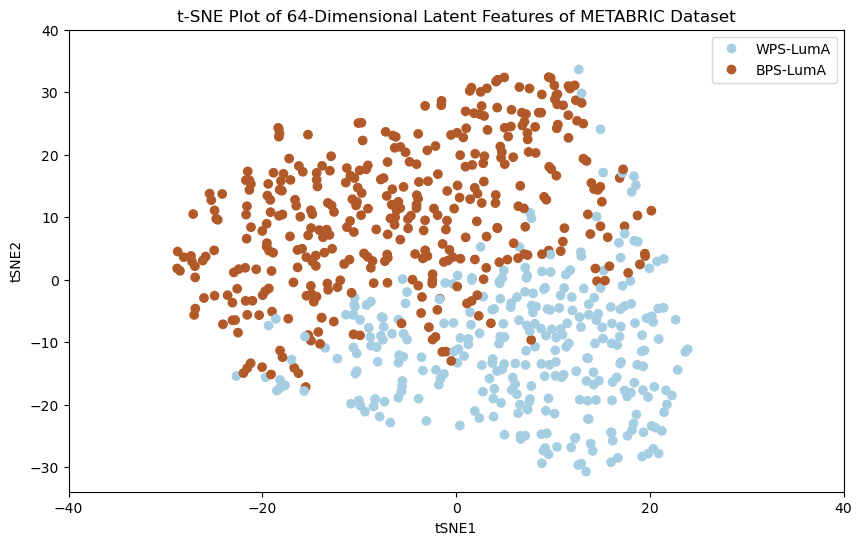

In [767]:
# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_metabric = tsne.fit_transform(metabric_latent)
colors = ['#020887', '#A9DBB8']
# Plot the t-SNE results
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne_metabric[:, 0], tsne_metabric[:, 1], c=cluster_metabric, cmap='Paired', label='METABRIC')
#plt.scatter(tsne_tcga[:, 0], tsne_tcga[:, 1], c=cluster_tcga, cmap='viridis', marker='s', label='TCGA')
plt.title('t-SNE Plot of 64-Dimensional Latent Features of METABRIC Dataset')
plt.xlabel('tSNE1')
plt.ylabel('tSNE2')
plt.xticks([40, 20, 0, -20, -40])
plt.yticks([40, 30, 20, 10, 0, -10, -20, -30])
plt.legend(handles=scatter.legend_elements()[0], labels=['WPS-LumA', 'BPS-LumA'])
plt.show()

-------------------------------------------------------------------------------------------------------------------------

**Survival Analysis**

In [ ]:
#need cluster_number, metabric_meta_dict, metabric_sample_ids ,cluster_metabric

In [792]:
true = '1:Recurred'
false = '0:Not Recurred'
labels = ["cluster" + str(i) for i in range(1, cluster_number + 1)]
groups = []
events = []
times = []

#Samples with valid RFS status labels and non-NaN RFM values are considered.
#The group assignment, event (recurrence or not), and survival time are added to the respective lists.
for i in range(0, len(metabric_sample_ids)):
    if metabric_meta_dict[metabric_sample_ids[i]]["RFS"] == true or metabric_meta_dict[metabric_sample_ids[i]]["RFS"] == false:
        rfm = float(metabric_meta_dict[metabric_sample_ids[i]]["RFM"])
        if math.isnan(rfm) == False:
            groups.append(cluster_metabric[i] + 1)
            times.append(float(metabric_meta_dict[metabric_sample_ids[i]]["RFM"]))
            if metabric_meta_dict[metabric_sample_ids[i]]["RFS"] == false:
                events.append(0)
            else:
                events.append(1)

inf
248.9499969482422
0.13662399894518554
[0.136624]


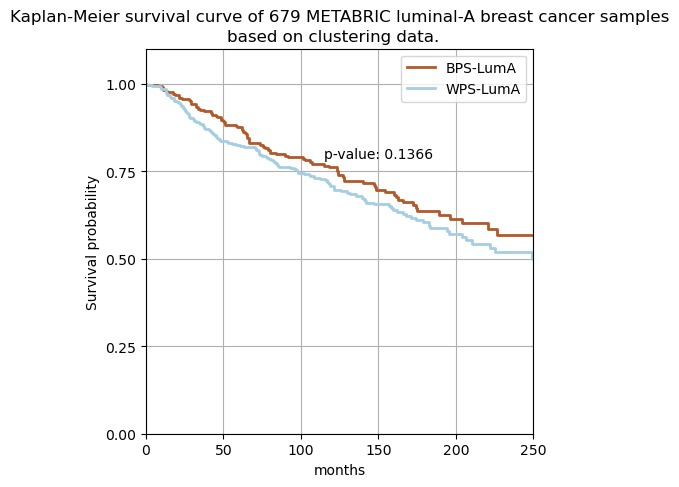

In [793]:
E = np.array(events, dtype=np.int32)
T = np.array(times, dtype=np.float32)
G = np.array(groups, dtype=np.int32)

#The KaplanMeierFitter from the lifelines library is used to estimate the survival function for each cluster.
kmf = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(5, 5))
color = ['#B15928', '#A6CEE3']
lw = 2

# loop used to fit and plot the Kaplan-Meier curves for each cluster
for i in set(cluster_metabric):
    ix = np.array(groups) == (i + 1)
    kmf.fit(T[ix], event_observed=E[ix], label=labels[i])
    kmf.plot(ax=ax, ci_show=False, linewidth=lw, style="-", color=color[i])
    print(kmf.median_survival_time_)

#The multivariate_logrank_test is applied to test the null hypothesis that the survival curves for different groups are the same.
result = multivariate_logrank_test(T, G, E)
pvalue = result.p_value
print(pvalue)

#The pairwise_logrank_test is used to perform pairwise comparisons between groups.
result_pair = pairwise_logrank_test(T, G, E)
print(result_pair.p_value)
plt.title('Kaplan-Meier survival curve of 679 METABRIC luminal-A breast cancer samples', y=1.05)
plt.suptitle('based on clustering data.', y=0.92, fontsize=12)
plt.xticks([0, 50, 100, 150, 200, 250])
plt.yticks([0.00, 0.25, 0.50, 0.75, 1.00])
plt.xlim([0, 250])
plt.ylim([0, 1.1])
plt.legend(["BPS-LumA", "WPS-LumA"])
plt.xlabel("months")
plt.ylabel("Survival probability")
plt.grid()
plt.text(150, 0.8, f'p-value: {pvalue:.4f}', ha='center', va='center')
plt.show()


Comparing to their autoencoder with the accepted subgroups fro their supplemental data.

In [752]:
accepted_subgroups = pd.read_csv(ROOT_PATH+"/metabric_metadata.txt", delimiter="\t")

In [753]:
accepted_subgroups

,sample,subgroup
0,MB-0306,BPS_LumA
1,MB-4825,WPS-LumA
2,MB-5048,WPS-LumA
3,MB-4599,WPS-LumA
4,MB-0263,BPS_LumA
...,...,...
674,MB-5464,WPS-LumA
675,MB-5011,WPS-LumA
676,MB-4999,WPS-LumA
677,MB-7056,WPS-LumA


In [754]:
subgroup = []

for i in range(len(accepted_subgroups)):
    # Access the 'sample' column for the current row
    current_sample = accepted_subgroups['sample'][i]
    
    # Check the subgroup for the current sample
    if accepted_subgroups['subgroup'][i] == "BPS_LumA":
        subgroup.append(0)
    else:
        subgroup.append(1)
print(subgroup)

[0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 

inf
210.38999938964844
5.819790070170727e-05
[5.81979007e-05]


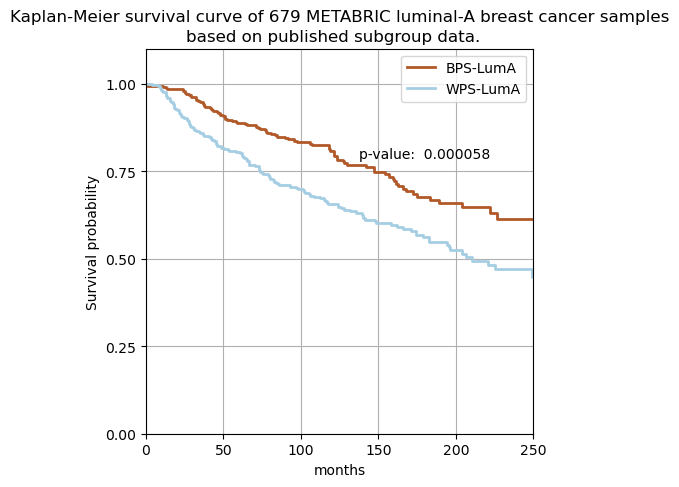

In [791]:
true = '1:Recurred'
false = '0:Not Recurred'
labels = ["cluster" + str(i) for i in range(1, cluster_number + 1)]
groups = []
events = []
times = []

#Samples with valid RFS status labels and non-NaN RFM values are considered.
#The group assignment, event (recurrence or not), and survival time are added to the respective lists.
for i in range(0, len(metabric_sample_ids)):
    if metabric_meta_dict[metabric_sample_ids[i]]["RFS"] == true or metabric_meta_dict[metabric_sample_ids[i]]["RFS"] == false:
        rfm = float(metabric_meta_dict[metabric_sample_ids[i]]["RFM"])
        if math.isnan(rfm) == False:
            groups.append(subgroup[i] + 1)
            times.append(float(metabric_meta_dict[metabric_sample_ids[i]]["RFM"]))
            if metabric_meta_dict[metabric_sample_ids[i]]["RFS"] == false:
                events.append(0)
            else:
                events.append(1)
E = np.array(events, dtype=np.int32)
T = np.array(times, dtype=np.float32)
G = np.array(groups, dtype=np.int32)

#The KaplanMeierFitter from the lifelines library is used to estimate the survival function for each cluster.
kmf = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(5, 5))
lw = 2

# loop used to fit and plot the Kaplan-Meier curves for each cluster
for i in set(subgroup):
    ix = np.array(groups) == (i + 1)
    kmf.fit(T[ix], event_observed=E[ix], label=labels[i])
    kmf.plot(ax=ax, ci_show=False, linewidth=lw, style="-", color=color[i])
    print(kmf.median_survival_time_)

#The multivariate_logrank_test is applied to test the null hypothesis that the survival curves for different groups are the same.
result = multivariate_logrank_test(T, G, E)
pvalue = result.p_value
print(pvalue)

#The pairwise_logrank_test is used to perform pairwise comparisons between groups.
result_pair = pairwise_logrank_test(T, G, E)
print(result_pair.p_value)

plt.title('Kaplan-Meier survival curve of 679 METABRIC luminal-A breast cancer samples', y=1.05)
plt.suptitle('based on published subgroup data.', y=0.92, fontsize=12)
plt.xticks([0, 50, 100, 150, 200, 250])
plt.yticks([0.00, 0.25, 0.50, 0.75, 1.00])
plt.xlim([0, 250])
plt.ylim([0, 1.1])
plt.legend(["BPS-LumA", "WPS-LumA"])
plt.xlabel("months")
plt.ylabel("Survival probability")
plt.text(180, 0.8, f'p-value: {pvalue: .6f}', ha='center', va='center')
plt.grid()
plt.show()